# Imports

In [55]:
%%time

import numpy
import pandas
from mpl_toolkits.mplot3d import Axes3D
import seaborn
import matplotlib.pyplot as plt

%matplotlib inline
%pylab inline

seaborn.set_style('whitegrid')


Populating the interactive namespace from numpy and matplotlib
Wall time: 2.84 s


# Homicide reports 1980-2014
## Reading & filtering data
### First attempt to read data

In [56]:
homicide = pandas.read_csv("./datasets/homocide_reports_1980-2014.csv.gz") \
                            .drop(['Record ID', 'Agency Code'], axis=1)
homicide.head()

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Agency Name,Agency Type,City,State,Year,Month,Incident,Crime Type,Crime Solved,Victim Sex,...,Victim Ethnicity,Perpetrator Sex,Perpetrator Age,Perpetrator Race,Perpetrator Ethnicity,Relationship,Weapon,Victim Count,Perpetrator Count,Record Source
0,Anchorage,Municipal Police,Anchorage,Alaska,1980,January,1,Murder or Manslaughter,Yes,Male,...,Unknown,Male,15,Native American/Alaska Native,Unknown,Acquaintance,Blunt Object,0,0,FBI
1,Anchorage,Municipal Police,Anchorage,Alaska,1980,March,1,Murder or Manslaughter,Yes,Male,...,Unknown,Male,42,White,Unknown,Acquaintance,Strangulation,0,0,FBI
2,Anchorage,Municipal Police,Anchorage,Alaska,1980,March,2,Murder or Manslaughter,No,Female,...,Unknown,Unknown,0,Unknown,Unknown,Unknown,Unknown,0,0,FBI
3,Anchorage,Municipal Police,Anchorage,Alaska,1980,April,1,Murder or Manslaughter,Yes,Male,...,Unknown,Male,42,White,Unknown,Acquaintance,Strangulation,0,0,FBI
4,Anchorage,Municipal Police,Anchorage,Alaska,1980,April,2,Murder or Manslaughter,No,Female,...,Unknown,Unknown,0,Unknown,Unknown,Unknown,Unknown,0,1,FBI


### Perpetrator age contains int try and convert to int

In [57]:
homicide = pandas.read_csv("./datasets/homocide_reports_1980-2014.csv.gz", dtype={"Perpetrator Age": int}) \
                            .drop(['Record ID', 'Agency Code'], axis=1)
homicide[homicide['Perpetrator Age'] == ' '].head()

ValueError: invalid literal for int() with base 10: ' '

### Check dirty data field

In [58]:
homicide = pandas.read_csv("./datasets/homocide_reports_1980-2014.csv.gz", dtype={"Perpetrator Age": object}) \
                            .drop(['Record ID', 'Agency Code'], axis=1)
homicide[homicide['Perpetrator Age'] == ' '].head()

,Agency Name,Agency Type,City,State,Year,Month,Incident,Crime Type,Crime Solved,Victim Sex,...,Victim Ethnicity,Perpetrator Sex,Perpetrator Age,Perpetrator Race,Perpetrator Ethnicity,Relationship,Weapon,Victim Count,Perpetrator Count,Record Source
634666,Tulsa,Municipal Police,Tulsa,Oklahoma,2014,June,104,Murder or Manslaughter,No,Male,...,Not Hispanic,Unknown,,Unknown,Unknown,Unknown,Handgun,0,0,FBI


### Filter and generalize data and save to a csv for future use

In [59]:
%%time

homicide = pandas.read_csv("./datasets/homocide_reports_1980-2014.csv.gz", dtype={"Perpetrator Age": object}) \
                            .drop(['Record ID', 'Agency Code'], axis=1)
# Perpetrator Age contains dirty data

homicide['Perpetrator Age'] = homicide['Perpetrator Age'].replace(' ', 0).apply(pandas.to_numeric)

homicide.loc[(homicide['Relationship'] == 'Wife') | (homicide['Relationship'] == 'Ex-Wife') |
             (homicide['Relationship'] == 'Girlfriend') |
             (homicide['Relationship'] == 'Common-Law Wife'), 'Rel_Category'] = 'Partner-F'

homicide.loc[(homicide['Relationship'] == 'Husband') | (homicide['Relationship'] == 'Ex-Husband') |
             (homicide['Relationship'] == 'Boyfriend') |
             (homicide['Relationship'] == 'Common-Law Husband'), 'Rel_Category'] = 'Partner-M'

homicide.loc[(homicide['Relationship'] == 'Father') | (homicide['Relationship'] == 'In-Law') |
             (homicide['Relationship'] == 'Mother') | (homicide['Relationship'] == 'Stepfather') |
             (homicide['Relationship'] == 'Stepmother'), 'Rel_Category'] = 'Parent'

homicide.loc[(homicide['Relationship'] == 'Daughter') | (homicide['Relationship'] == 'Son') |
             (homicide['Relationship'] == 'Stepdaughter') |
             (homicide['Relationship'] == 'Stepson'), 'Rel_Category'] = 'Children'

homicide.loc[(homicide['Relationship'] == 'Brother') | (homicide['Relationship'] == 'Sister'),
             'Rel_Category'] = 'Sibling'

homicide.loc[(homicide['Relationship'] == 'Employee') | (homicide['Relationship'] == 'Employer'),
             'Rel_Category'] = 'Work'

homicide.loc[(homicide['Relationship'] == 'Boyfriend/Girlfriend') & (homicide['Victim Sex'] == 'Female'),
             'Rel_Category'] = 'Partner-F'

homicide.loc[(homicide['Relationship'] == 'Boyfriend/Girlfriend') & ((homicide['Victim Sex'] == 'Male') |
            (homicide['Victim Sex'] == 'Unknown')), 'Rel_Category'] = 'Partner-M'

homicide.head(10)
homicide.to_csv('./datasets/homocide_reports_1980-2014_filtered.csv.gz', compression='gzip')

Wall time: 2min 20s


### Load pre-filtered csv

In [60]:
%time homicide = pandas.read_csv("./datasets/homocide_reports_1980-2014_filtered.csv.gz")

Wall time: 6.61 s


### Check if we have null fields in our columns

In [61]:
%time homicide.isnull().any()

Wall time: 3.01 s


Unnamed: 0               False
Agency Name              False
Agency Type              False
City                     False
State                    False
Year                     False
Month                    False
Incident                 False
Crime Type               False
Crime Solved             False
Victim Sex               False
Victim Age               False
Victim Race              False
Victim Ethnicity         False
Perpetrator Sex          False
Perpetrator Age          False
Perpetrator Race         False
Perpetrator Ethnicity    False
Relationship             False
Weapon                   False
Victim Count             False
Perpetrator Count        False
Record Source            False
Rel_Category              True
dtype: bool

### Check types per comumn

In [62]:
%time homicide.dtypes

Wall time: 1.5 ms


Unnamed: 0                int64
Agency Name              object
Agency Type              object
City                     object
State                    object
Year                      int64
Month                    object
Incident                  int64
Crime Type               object
Crime Solved             object
Victim Sex               object
Victim Age                int64
Victim Race              object
Victim Ethnicity         object
Perpetrator Sex          object
Perpetrator Age           int64
Perpetrator Race         object
Perpetrator Ethnicity    object
Relationship             object
Weapon                   object
Victim Count              int64
Perpetrator Count         int64
Record Source            object
Rel_Category             object
dtype: object

### Print description of our data set

In [63]:
%time homicide.describe()

Wall time: 1.24 s


,Unnamed: 0,Year,Incident,Victim Age,Perpetrator Age,Victim Count,Perpetrator Count
count,638454.00000,638454.000000,638454.000000,638454.000000,638454.000000,638454.000000,638454.000000
mean,319226.50000,1995.801102,22.967924,35.033512,20.322665,0.123334,0.185224
std,184305.93872,9.927693,92.149821,41.628306,17.886846,0.537733,0.585496
min,0.00000,1980.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,159613.25000,1987.000000,1.000000,22.000000,0.000000,0.000000,0.000000
50%,319226.50000,1995.000000,2.000000,30.000000,21.000000,0.000000,0.000000
75%,478839.75000,2004.000000,10.000000,42.000000,31.000000,0.000000,0.000000
max,638453.00000,2014.000000,999.000000,998.000000,99.000000,10.000000,10.000000


### Show pepetrator sex and victim sex

In [64]:
%time pandas.crosstab(homicide['Victim Sex'], homicide['Perpetrator Sex'])

Wall time: 667 ms


Perpetrator Sex,Female,Male,Unknown
Victim Sex,,,
Female,10869,99381,33095
Male,37629,299879,156617
Unknown,50,281,653


### Show weapon use by sex

Wall time: 1.73 s
Parser   : 176 ms


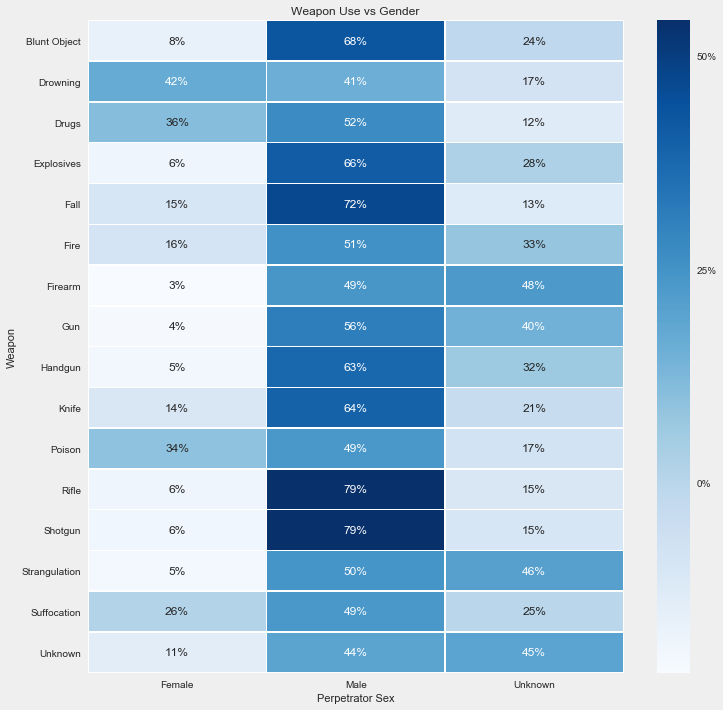

In [65]:
%%time

pyplot.figure(figsize=(12, 12), facecolor='#efefef')
seaborn.set()
ax = seaborn.heatmap(pandas.crosstab(homicide.Weapon, homicide['Perpetrator Sex'])
                     .apply(lambda r: r / r.sum(), axis=1), annot=True, fmt=".0%", linewidths=.5, cmap='Blues')
ax.set_title('Weapon Use vs Gender')
cbar = ax.collections[0].colorbar
cbar.set_ticks([0, .25, .50, .75, 1])
cbar.set_ticklabels(['0%', '25%', '50%', '75%', '100%'])
ax.plot()


### Show weapon use by sex with unkown filtered out.

Wall time: 2.34 s


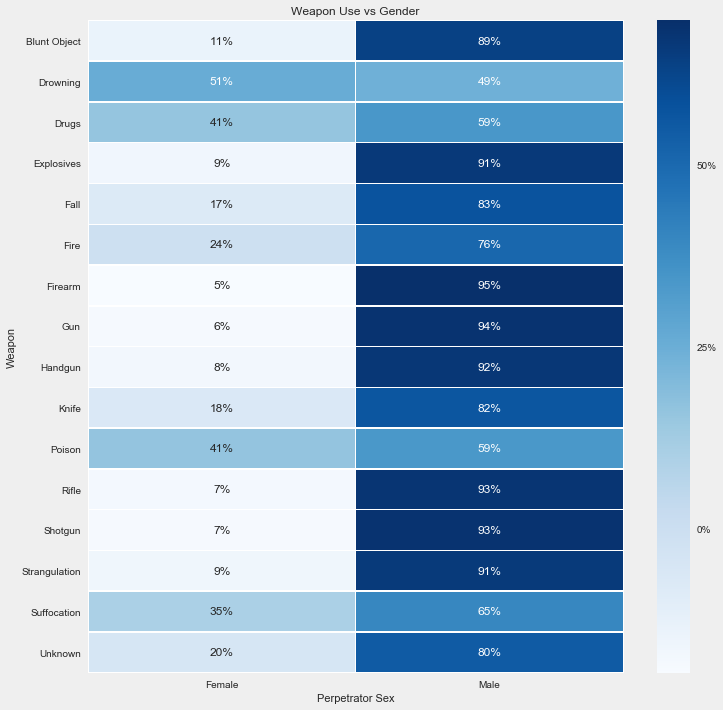

In [66]:
%%time

pyplot.figure(figsize=(12, 12), facecolor='#efefef')
seaborn.set()
# ax.set_ticklabels(['0%', '20%', '75%', '100%'])
unknown_filter = homicide[homicide['Perpetrator Sex'] != 'Unknown']
ax = seaborn.heatmap(pandas.crosstab(unknown_filter.Weapon, unknown_filter['Perpetrator Sex'])
                     .apply(lambda r: r / r.sum(), axis=1), annot=True, fmt=".0%", linewidths=.5, cmap='Blues')
ax.set_title('Weapon Use vs Gender')
cbar = ax.collections[0].colorbar
cbar.set_ticks([0, .25, .50, .75, 1])
cbar.set_ticklabels(['0%', '25%', '50%', '75%', '100%'])
ax.plot()


### Amount of homicides per month

Wall time: 3.71 s


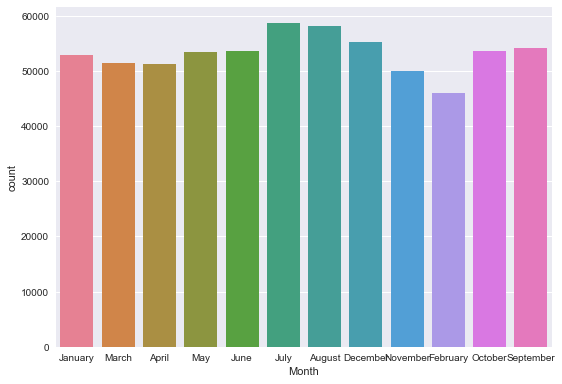

In [67]:
%%time

seaborn.countplot(x='Month', data=homicide, palette="husl")
seaborn.plt.tight_layout()


### Show perpetrator age with unkown ages filtered out

Wall time: 4.16 s


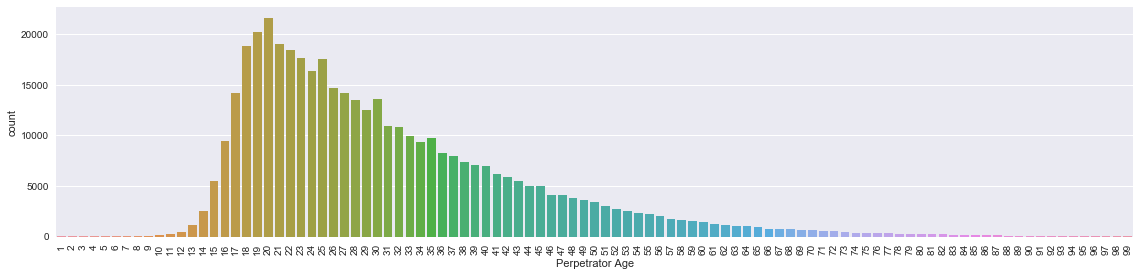

In [68]:
%%time

s = seaborn.factorplot(x='Perpetrator Age', data=homicide[homicide['Perpetrator Age'] != 0],
                        kind="count", aspect=4)
s.set_xticklabels(rotation=90)
seaborn.plt.tight_layout()


### Show perpetrator age with unkown ages filtered out grouped 

Wall time: 6.33 s


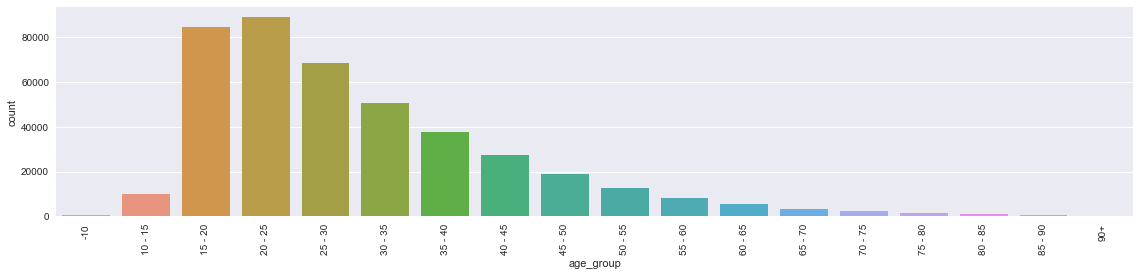

In [89]:
%%time
bins = [0,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,np.inf]
labels = ['-10','10 - 15','15 - 20','20 - 25','25 - 30','30 - 35','35 - 40','40 - 45','45 - 50','50 - 55','55 - 60','60 - 65','65 - 70','70 - 75','75 - 80','80 - 85', '85 - 90', '90+']
age_groups = pandas.cut(homicide['Perpetrator Age'], bins, labels=labels)
homicide['age_group'] = age_groups

s = seaborn.factorplot(x='age_group', data=homicide[homicide['Perpetrator Age'] != 0],
                        kind="count", aspect=4)
s.set_xticklabels(rotation=90)
seaborn.plt.tight_layout()

### Show homcide count by race

Wall time: 3.66 s


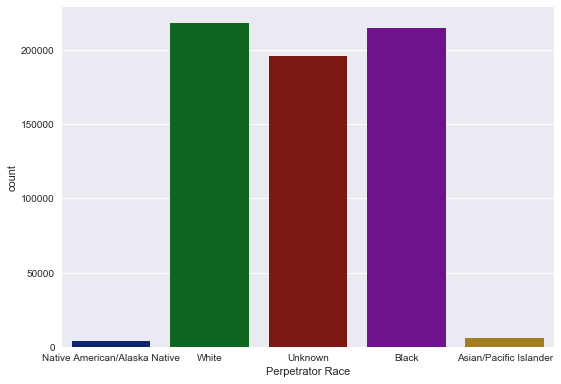

In [69]:
%%time

seaborn.countplot(x='Perpetrator Race', data=homicide, palette="dark")
seaborn.plt.tight_layout()


### Pepetrator gender vs weapon used

Wall time: 1.28 s


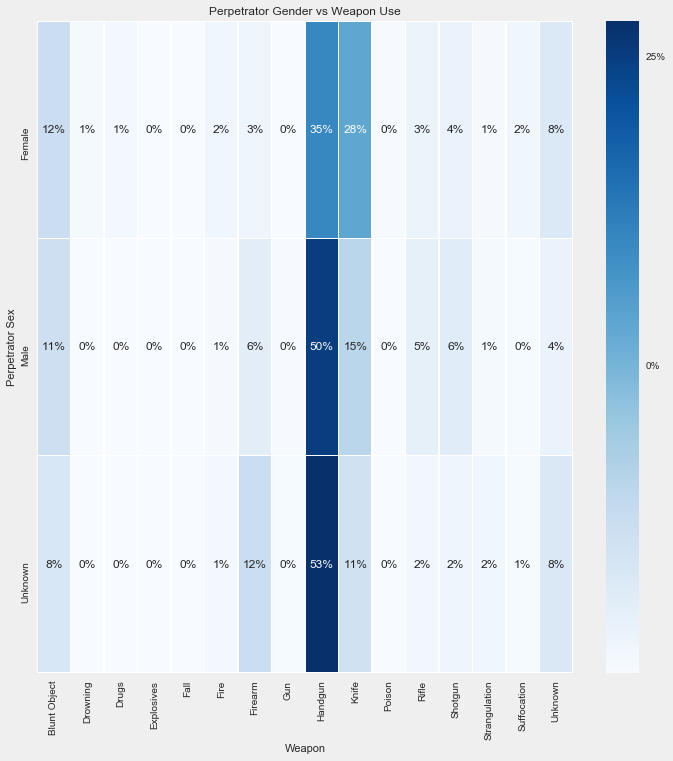

In [70]:
%%time

plt.figure(figsize=(12, 12), facecolor='#efefef')
seaborn.set()
# ax.set_ticklabels(['0%', '25%', '75%', '100%'])
ax = seaborn.heatmap(pandas.crosstab(homicide['Perpetrator Sex'], homicide.Weapon).apply(lambda r: r / r.sum(), axis=1),
                     annot=True, fmt=".0%", linewidths=.5, cmap='Blues')
ax.set_title('Perpetrator Gender vs Weapon Use')
cbar = ax.collections[0].colorbar
cbar.set_ticks([0, .25, .50, .75, 1])
cbar.set_ticklabels(['0%', '25%', '50%', '75%', '100%'])


### Count of homcides per state

Wall time: 4.18 s


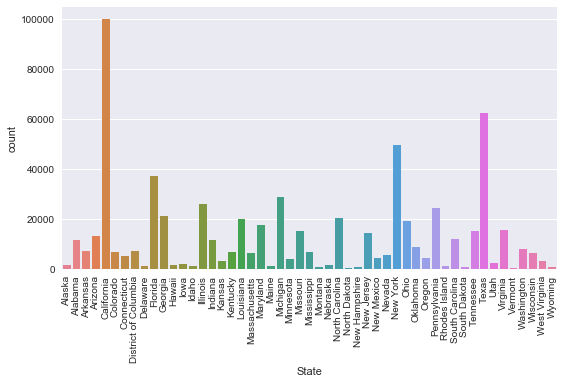

In [76]:
%%time

seaborn.countplot(x='State', data=homicide, palette="husl")

locs, labels = plt.xticks()
plt.setp(labels, rotation=90)

seaborn.plt.tight_layout()


# Sex offenders
## Read data set

In [77]:
%%time

sexoff = pandas.read_csv("./datasets/Sex_Offenders.csv", dtype={"AGE": int})

Wall time: 453 ms


## Show data

In [78]:
%time sexoff.head(10)

Wall time: 1.5 ms


,LAST,FIRST,BLOCK,GENDER,RACE,BIRTH DATE,AGE,HEIGHT,WEIGHT,VICTIM MINOR
0,NIEVES,EDUARDO,033XX W CRYSTAL ST,MALE,WHITE HISPANIC,10/07/1968,48,600,200,Y
1,VALDEZ,JOSE,023XX W 23RD ST,MALE,WHITE HISPANIC,10/07/1976,40,602,235,N
2,CRAWFORD,ANDRE,11XXX S STATE ST,MALE,BLACK,10/07/1964,52,507,155,Y
3,MARTINEZ,SERGIO,054XX S ARCHER AVE,MALE,WHITE HISPANIC,10/07/1960,56,504,155,Y
4,CANCIO-HERNANDEZ,ERNESTO,015XX W GARFIELD BLVD,MALE,WHITE HISPANIC,10/08/1941,75,507,140,Y
5,URENDA,NOE,025XX W 46TH ST,MALE,WHITE HISPANIC,10/08/1973,43,506,164,Y
6,PAZ,JUAN,052XX S KILBOURN AVE,MALE,WHITE HISPANIC,10/09/1981,35,509,300,Y
7,MYLES,ROOSEVELT,002XX E 121ST ST,MALE,BLACK,10/09/1958,58,502,225,Y
8,WALTON,MARION,032XX N CICERO AVE,MALE,WHITE,10/09/1947,69,508,164,Y
9,DAVIS,DUANE,081XX S CAMPBELL AVE,MALE,BLACK,10/10/1961,55,511,180,Y


## Check if tables contain null

In [79]:
%time sexoff.isnull().any()

Wall time: 8 ms


LAST            False
FIRST           False
BLOCK           False
GENDER          False
RACE            False
BIRTH DATE      False
AGE             False
HEIGHT          False
WEIGHT          False
VICTIM MINOR    False
dtype: bool

## Check data types

In [80]:
%time sexoff.dtypes

Wall time: 505 µs


LAST            object
FIRST           object
BLOCK           object
GENDER          object
RACE            object
BIRTH DATE      object
AGE              int32
HEIGHT           int64
WEIGHT           int64
VICTIM MINOR    object
dtype: object

## Show sex offenders by race

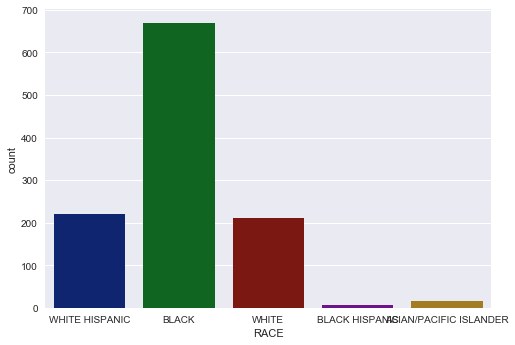

Wall time: 867 ms


In [81]:
%%time

seaborn.countplot(x='RACE', data=sexoff, palette="dark")
seaborn.plt.show()


## Show amount of sex offenders by age when crime was commited

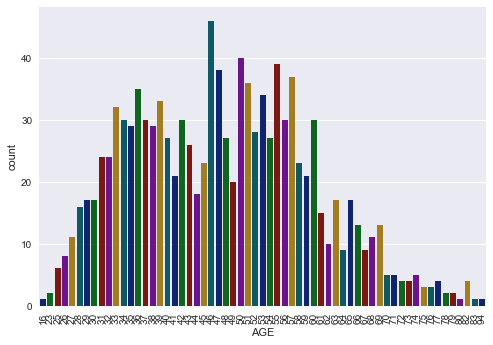

Wall time: 2.6 s


In [86]:
%%time

seaborn.countplot(x='AGE', data=sexoff, palette="dark")

locs, labels = plt.xticks()
plt.setp(labels, rotation=90)

seaborn.plt.show()


# titel Show amount of sex offenders grouped by age when crime was commited 

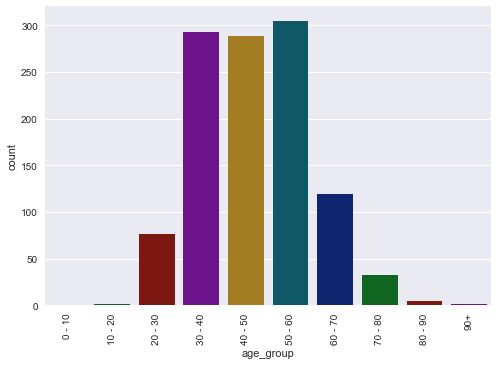

Wall time: 906 ms


In [82]:
%%time

bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, np.inf]
labels = ['0 - 10', '10 - 20', '20 - 30', '30 - 40', '40 - 50', '50 - 60', '60 - 70', '70 - 80', '80 - 90', '90+']
age_groups = pandas.cut(sexoff.AGE, bins, labels=labels)
sexoff['age_group'] = age_groups

seaborn.countplot(x='age_group', data=sexoff, palette="dark")

locs, labels = plt.xticks()
plt.setp(labels, rotation=90)

seaborn.plt.show()

## Show amount of sex offenders by gender

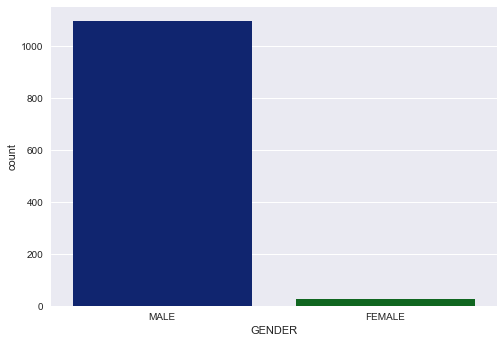

Wall time: 587 ms


In [90]:
%%time

seaborn.countplot(x='GENDER', data=sexoff, palette="dark")
seaborn.plt.show()

## Show amount of sex offenders by height

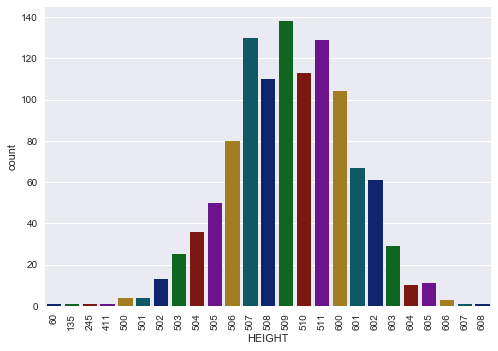

Wall time: 1.16 s


In [91]:
%%time

seaborn.countplot(x='HEIGHT', data=sexoff, palette="dark")

locs, labels = plt.xticks()
plt.setp(labels, rotation=90)

seaborn.plt.show()


## Show amount of minor victims

In [ ]:
%%time

seaborn.countplot(x='VICTIM MINOR', data=sexoff, palette="dark")
seaborn.plt.show()


## Show amount of minor and no minor victims by targeted by offender sex

In [ ]:
%%time

seaborn.countplot(x='GENDER', hue='VICTIM MINOR', data=sexoff, palette="Paired")
seaborn.plt.show()


# Gun offenders in chicago
## Read data

In [ ]:
%%time

gunoff = pandas.read_csv("./datasets/Gun_Offenders.csv")


## Print first 10 rows

In [ ]:
%time gunoff.head(10)


## Check if our columns contains null data

In [ ]:
%time gunoff.isnull().any()


## Check which types our columns conain

In [ ]:
%time gunoff.dtypes


## Show amount of gun offenders by race

In [ ]:
%%time

seaborn.countplot(x='race', data=gunoff, palette="dark")
seaborn.plt.show()


## Show amount of gun offenders by age

In [ ]:
%%time

seaborn.countplot(x='sex', data=gunoff, palette="dark")
seaborn.plt.show()


## Show ammount of gun offenders per state

In [ ]:
%%time

seaborn.countplot(x='state', data=gunoff, palette="dark")

locs, labels = plt.xticks()
plt.setp(labels, rotation=90)

seaborn.plt.show()


# Map US met hopelijk usefull data.



In [ ]:
%%time
 

state_geo = './datatsets/state.geo.json'



#Let Folium determine the scale
map = folium.Map(location=[48, -102], zoom_start=3)
map.geo_json(geo_path=state_geo, data=homicide,
             columns=['State'],
             key_on='feature.id',
             fill_color='YlGn', fill_opacity=0.7, line_opacity=0.2,
             legend_name='Murders(%)')
map